# Denoising Diffusion Probabilistic Models

In [1]:
import flax.linen as nn
import jax
import jax.numpy as jnp
import jax.random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tqdm
from sklearn import metrics

In [2]:
def q(x0, at, rng):
    return jnp.sqrt(at) * x0 + jnp.sqrt(1 - at) * jax.random.normal(rng, x0.shape)

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = jnp.array(X_train / 127.5 - 1)
X_test = jnp.array(X_test / 127.5 - 1)

In [4]:
rng = jax.random.PRNGKey(0)

Below, we can see the forward diffusion process.

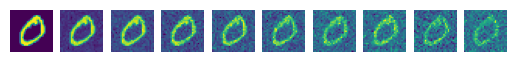

In [5]:
bt = jnp.linspace(0, 1, num=100)
at = jnp.cumprod(1 - bt)
r = rng

T = 10
_, arr = plt.subplots(1, T)
for i in range(T):
    r, _ = jax.random.split(r)
    arr[i].imshow(
        q(X_train[1], at[i], r)
    )
    arr[i].axis("off")

In [75]:
def mlp(p, X):
    S = jnp.zeros_like(X)
    for l, (W, b) in enumerate(p):
        if (l + 1) == len(p):
            X = X + S
        X = X @ W + b
        if l == 0:
            S = X
        if (l + 1) < len(p):
            X = nn.relu(X)
    return X


@jax.jit
def train_step(p, X, eps, eta):
    def loss(p):
        eps_hat = mlp(p, X)
        return jnp.mean(jnp.linalg.norm(eps - eps_hat, axis=1) ** 2)

    l, G = jax.value_and_grad(loss)(p)
    return update_params(p, G, eta), l


def update_params(p, G, eta):
    return jax.tree_map(lambda w, g: w - eta * g, p, G)

In [7]:
def get_batch_indices(rng, dataset_size, batch_size):
    steps_per_epoch = dataset_size // batch_size

    perms = jax.random.permutation(rng, dataset_size)
    perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))
    return perms

In [8]:
def kaiming(n):
    return jnp.sqrt(2 / n)

def init_layer(shape, rng):
    kW, kb = jax.random.split(rng)
    s = kaiming(shape[-1])
    W = jax.random.normal(kW, shape) * s
    b = jax.random.normal(kb, shape[-1:]) * s
    return W, b

In [103]:
def pos_enc(t, d):
    k = jnp.arange(0, d, 2, dtype=jnp.float32) / d
    z = t.reshape(-1, 1) / (10_000 ** k)

    s = jnp.sin(z)
    c = jnp.cos(z)
    return jnp.zeros((len(t), d), dtype=jnp.float32).at[:, 0::2].set(s).at[:, 1::2].set(c)


In [101]:
p0 = ()
r = rng

for shape in [
    (28 ** 2 + 4, 512),
    (512, 256),
    (256, 512),
    (512, 28 ** 2)
]:
    _, _, r = jax.random.split(r, 3)
    p0 = p0 + (init_layer(shape, r),)

In [104]:
T = 1000
bt = jnp.linspace(1e-4, 0.02, num=T)
at = jnp.cumprod(1 - bt).reshape(-1, 1)
r = rng
p = p0

E = 500
B = 1024
X = X_train.reshape(len(X_train), -1)
for e in range(E):
    r, r0 = jax.random.split(r)
    ix = get_batch_indices(r0, len(X_train), B)

    L = jnp.array(0)
    for i in tqdm.tqdm(ix, desc=f"Epoch {e}"):
        r, r0, r1, r2 = jax.random.split(r, 4)

        t = jax.random.categorical(r0, jnp.zeros(T) - jnp.log(T), shape=i.shape)
        X_ = X[i]
        eps = jax.random.normal(r2, X_.shape)
        X_t = jnp.sqrt(at[t]) * X_ + jnp.sqrt(1 - at[t]) * eps

        p, l = train_step(
            p,
            jnp.hstack((X_t, pos_enc(t, 4))),
            # X_t,
            eps,
            eta=1e-3
        )
        L += l
    print(f"Mean error of epoch {e}: {(L / len(ix)).item():.3f}")


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 22.16it/s]


Mean error of epoch 0: 2134.615


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.28it/s]


Mean error of epoch 1: 1076.789


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.35it/s]


Mean error of epoch 2: 764.560


Epoch 3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.13it/s]


Mean error of epoch 3: 621.513


Epoch 4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.58it/s]


Mean error of epoch 4: 544.772


Epoch 5: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.62it/s]


Mean error of epoch 5: 497.896


Epoch 6: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.31it/s]


Mean error of epoch 6: 467.707


Epoch 7: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.66it/s]


Mean error of epoch 7: 446.682


Epoch 8: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.84it/s]


Mean error of epoch 8: 430.034


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.20it/s]


Mean error of epoch 9: 418.643


Epoch 10: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.66it/s]


Mean error of epoch 10: 409.117


Epoch 11: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.43it/s]


Mean error of epoch 11: 400.862


Epoch 12: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.65it/s]


Mean error of epoch 12: 394.764


Epoch 13: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.67it/s]


Mean error of epoch 13: 388.916


Epoch 14: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.12it/s]


Mean error of epoch 14: 383.200


Epoch 15: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.41it/s]


Mean error of epoch 15: 379.027


Epoch 16: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.71it/s]


Mean error of epoch 16: 375.740


Epoch 17: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.48it/s]


Mean error of epoch 17: 372.759


Epoch 18: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.20it/s]


Mean error of epoch 18: 368.802


Epoch 19: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.35it/s]


Mean error of epoch 19: 366.169


Epoch 20: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.04it/s]


Mean error of epoch 20: 363.136


Epoch 21: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.55it/s]


Mean error of epoch 21: 361.899


Epoch 22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.34it/s]


Mean error of epoch 22: 360.506


Epoch 23: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.32it/s]


Mean error of epoch 23: 357.769


Epoch 24: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.33it/s]


Mean error of epoch 24: 356.443


Epoch 25: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.25it/s]


Mean error of epoch 25: 354.568


Epoch 26: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.45it/s]


Mean error of epoch 26: 353.262


Epoch 27: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.51it/s]


Mean error of epoch 27: 352.324


Epoch 28: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.54it/s]


Mean error of epoch 28: 351.257


Epoch 29: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.25it/s]


Mean error of epoch 29: 349.879


Epoch 30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.98it/s]


Mean error of epoch 30: 348.717


Epoch 31: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.78it/s]


Mean error of epoch 31: 349.628


Epoch 32: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 22.93it/s]


Mean error of epoch 32: 348.153


Epoch 33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.29it/s]


Mean error of epoch 33: 347.500


Epoch 34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.89it/s]


Mean error of epoch 34: 346.557


Epoch 35: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 21.64it/s]


Mean error of epoch 35: 346.416


Epoch 36: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 21.32it/s]


Mean error of epoch 36: 346.099


Epoch 37: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 22.45it/s]


Mean error of epoch 37: 344.850


Epoch 38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 22.91it/s]


Mean error of epoch 38: 345.240


Epoch 39: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.20it/s]


Mean error of epoch 39: 344.539


Epoch 40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.82it/s]


Mean error of epoch 40: 344.097


Epoch 41: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.75it/s]


Mean error of epoch 41: 343.817


Epoch 42: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.50it/s]


Mean error of epoch 42: 342.930


Epoch 43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.78it/s]


Mean error of epoch 43: 343.588


Epoch 44: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.59it/s]


Mean error of epoch 44: 343.050


Epoch 45: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.96it/s]


Mean error of epoch 45: 341.675


Epoch 46: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.69it/s]


Mean error of epoch 46: 341.591


Epoch 47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.63it/s]


Mean error of epoch 47: 342.049


Epoch 48: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.76it/s]


Mean error of epoch 48: 341.861


Epoch 49: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.87it/s]


Mean error of epoch 49: 341.485


Epoch 50: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.46it/s]


Mean error of epoch 50: 340.544


Epoch 51: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.67it/s]


Mean error of epoch 51: 341.001


Epoch 52: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.51it/s]


Mean error of epoch 52: 339.435


Epoch 53: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.76it/s]


Mean error of epoch 53: 339.829


Epoch 54: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.02it/s]


Mean error of epoch 54: 339.122


Epoch 55: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 21.44it/s]


Mean error of epoch 55: 339.983


Epoch 56: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 22.14it/s]


Mean error of epoch 56: 339.615


Epoch 57: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 22.65it/s]


Mean error of epoch 57: 340.605


Epoch 58: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.38it/s]


Mean error of epoch 58: 338.660


Epoch 59: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.47it/s]


Mean error of epoch 59: 339.320


Epoch 60: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 22.95it/s]


Mean error of epoch 60: 337.916


Epoch 61: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 22.80it/s]


Mean error of epoch 61: 338.535


Epoch 62: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.06it/s]


Mean error of epoch 62: 338.240


Epoch 63: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 22.92it/s]


Mean error of epoch 63: 338.821


Epoch 64: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.16it/s]


Mean error of epoch 64: 337.742


Epoch 65: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.20it/s]


Mean error of epoch 65: 338.145


Epoch 66: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.09it/s]


Mean error of epoch 66: 338.008


Epoch 67: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.03it/s]


Mean error of epoch 67: 337.208


Epoch 68: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 22.95it/s]


Mean error of epoch 68: 338.189


Epoch 69: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.14it/s]


Mean error of epoch 69: 337.403


Epoch 70: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.06it/s]


Mean error of epoch 70: 336.519


Epoch 71: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.80it/s]


Mean error of epoch 71: 337.086


Epoch 72: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.92it/s]


Mean error of epoch 72: 337.253


Epoch 73: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.92it/s]


Mean error of epoch 73: 337.266


Epoch 74: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.75it/s]


Mean error of epoch 74: 336.017


Epoch 75: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.41it/s]


Mean error of epoch 75: 335.984


Epoch 76: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.12it/s]


Mean error of epoch 76: 337.252


Epoch 77: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.06it/s]


Mean error of epoch 77: 336.293


Epoch 78: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 22.14it/s]


Mean error of epoch 78: 336.579


Epoch 79: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.37it/s]


Mean error of epoch 79: 335.912


Epoch 80: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.57it/s]


Mean error of epoch 80: 335.937


Epoch 81: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.33it/s]


Mean error of epoch 81: 335.980


Epoch 82: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.31it/s]


Mean error of epoch 82: 335.587


Epoch 83: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.39it/s]


Mean error of epoch 83: 335.960


Epoch 84: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.27it/s]


Mean error of epoch 84: 335.714


Epoch 85: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.39it/s]


Mean error of epoch 85: 336.509


Epoch 86: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.22it/s]


Mean error of epoch 86: 336.458


Epoch 87: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.16it/s]


Mean error of epoch 87: 336.061


Epoch 88: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.88it/s]


Mean error of epoch 88: 334.406


Epoch 89: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.16it/s]


Mean error of epoch 89: 335.316


Epoch 90: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.29it/s]


Mean error of epoch 90: 335.961


Epoch 91: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 22.58it/s]


Mean error of epoch 91: 335.283


Epoch 92: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.13it/s]


Mean error of epoch 92: 335.044


Epoch 93: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.36it/s]


Mean error of epoch 93: 335.634


Epoch 94: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.28it/s]


Mean error of epoch 94: 335.352


Epoch 95: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.19it/s]


Mean error of epoch 95: 335.208


Epoch 96: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.71it/s]


Mean error of epoch 96: 334.764


Epoch 97: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.55it/s]


Mean error of epoch 97: 334.716


Epoch 98: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 24.16it/s]


Mean error of epoch 98: 334.891


Epoch 99: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 23.54it/s]

Mean error of epoch 99: 334.433


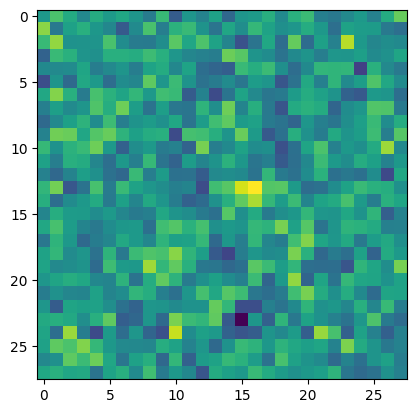

In [107]:
I = jax.random.normal(rng, (1, 28 ** 2))
for t_ in range(1, T + 1):
    I = I - mlp(p, jnp.hstack((I, pos_enc(jnp.array([[T - t_]]), 4))))

plt.imshow(I.reshape(28, 28))

## Appendix

Some additional derivations (for my own benefit)

### Variational lower bound

_a.k.a Evidence Lower Bound (ELBO)_

Suppose we want to know the marginal log probability $\log p(x)$ of random variable $x$, which is jointly distributed with latent variable $z$, such that:

$$
\log p(x) = \log \int p(x, z) \, dz
$$

Then, we have

$$\begin{align}
\log p(x) &= \log \int p(x, z) \, dz \\
&= \log \int p(x, z) \frac{p(z|x)}{p(z|x)} \, dz \\
&= \log \mathbb{E}_{p(z|x)}\left[\frac{p(x, z)}{p(z|x)}\right]
\end{align}$$

We then swap out the true posterior $p(z|x)$ with its variational approximation $q(z)$ and apply Jensen's inequality:

$$\begin{align}
\log \mathbb{E}_q\left[\frac{p(x, z)}{q(z)}\right] &\geq \mathbb{E}_q\left[\log \frac{p(x, z)}{q(z)}\right] \\
&= \mathbb{E}_q\left[\log p(x, z)\right] - \mathbb{E}_q[\log q(z)] \\
&= \mathbb{E}_q\left[\log p(x, z)\right] + \mathbb{H}_q[z]
\end{align}$$

where $\mathbb{H}_q[z]$ is the Shannon entropy of $z$.

In the case of DDPM, we have the the marginal $p(x_0) = \int p(x_{0:T}) \, dx_{1:T}$ (marginalising out the latents $x_{1:T}$). Applying the above, we get:

$$\begin{align}
\log p(x_0) &= \log \int p(x_{0:T}) \, dz \\
&= \log \int p(x_{0:T}) \frac{p(x_{1:T}|x_0)}{p(x_{1:T}|x_0)} \, dz \\
&= \log \mathbb{E}_{p(x_{1:T}|x_0)}\left[\frac{p(x_{0:T})}{p(x_{1:T}|x_0)}\right] \\
&\geq \mathbb{E}_{p(x_{1:T}|x_0)}\left[\log \frac{p(x_{0:T})}{p(x_{1:T}|x_0)}\right]
\end{align}$$

Again, we replace the the true posterior $p$ with the variational form $q$ (which in this case is the forward diffusion process):

$$
\mathbb{E}_{q(x_{1:T}|x_0)}\left[\log \frac{p(x_{0:T})}{q(x_{1:T}|x_0)}\right]
$$

Now, defining the reverse process $p$:

$$\begin{align}
p(x_{0:T}) &= p(x_T) \prod_{t = 1}^T p(x_{t - 1} | x_t) \\
% p(x_T) &= \mathcal{N}(x_T; 0, I) \\
% p(x_{t - 1} | x_t) &= \mathcal{N}(x_{t - 1}; \mu(x_t, t), \Sigma(x_t, t))
\end{align}$$

and the forward process $q$:

$$\begin{align}
q(x_{1:T} | x_0) &= \prod_{t = 1}^T q(x_t | x_{t - 1}) \\
% q(x_t | x_{t - 1}) &= \mathcal{N}(x_t; \sqrt{1 - \beta_t} x_{t - 1}, \beta_t I)
\end{align}$$

Placing these into the ELBO:

$$\begin{align}
\mathbb{E}_{q(x_{1:T}|x_0)}\left[\log \frac{p(x_{0:T})}{q(x_{1:T}|x_0)}\right] &= \mathbb{E}_{q(x_{1:T}|x_0)}\left[\log \frac{p(x_T) \prod_{t = 1}^T p(x_{t - 1} | x_t)}{\prod_{t = 1}^T q(x_t | x_{t - 1})}\right] \\
&= \mathbb{E}_{q(x_{1:T}|x_0)}\left[\log p(x_T) + \log \frac{\prod_{t = 1}^T p(x_{t - 1} | x_t)}{\prod_{t = 1}^T q(x_t | x_{t - 1})}\right] \\
&= \mathbb{E}_{q(x_{1:T}|x_0)}\left[\log p(x_T) + \sum_{t = 1}^T \log \frac{p(x_{t - 1} | x_t)}{q(x_t | x_{t - 1})}\right]
\end{align}$$

Since we are in the deep learning space, we will want to minimize a loss $L$ instead of maximising the log-likelihood. Hence, we multiply by $-1$:

$$
L := \mathbb{E}_{q(x_{1:T}|x_0)}\left[- \log p(x_T) - \sum_{t = 1}^T \log \frac{p(x_{t - 1} | x_t)}{q(x_t | x_{t - 1})}\right]
$$

et viola, we have Equation 3 from the paper.

### Closed Form $p(x_t)$

Next, we will try to recover Equation 4 from the paper. We start by defining the forward process $q$:

$$\begin{align}
q(x_{1:T} | x_0) &= \prod_{t = 1}^T q(x_t | x_{t - 1}) \\
q(x_t | x_{t - 1}) &= \mathcal{N}(x_t; \sqrt{1 - \beta_t} x_{t - 1}, \beta_t I)
\end{align}$$

via reparameterisation:

$$
x_t = \sqrt{1 - \beta_t} x_{t - 1} + \sqrt{\beta_t} \epsilon_t
$$

where

$$
\epsilon_t \sim \mathcal{N}(0, I)
$$

Expanding the recursive reparameterisation out a bit, we will start to see a pattern:

$$\begin{align}
x_{t + 1} &= \sqrt{1 - \beta_{t + 1}} \left( \sqrt{1 - \beta_t} x_{t - 1} + \sqrt{\beta_t} \epsilon_t \right) + \sqrt{\beta_{t + 1}} \epsilon_{t + 1} \\ 
&= \sqrt{1 - \beta_{t + 1}} \sqrt{1 - \beta_t} x_{t - 1} + \sqrt{1 - \beta_{t + 1}} \sqrt{\beta_t} \epsilon_t + \sqrt{\beta_{t + 1}} \epsilon_{t + 1} \\
&= \sqrt{(1 - \beta_{t + 1})(1 - \beta_t)} x_{t - 1} + \sqrt{\beta_t (1 - \beta_{t + 1})} \epsilon_t + \sqrt{\beta_{t + 1}} \epsilon_{t + 1}
\end{align}$$

Let's first consider the mean at timestep $t$. In the above expression we can see that we scale $x_{t - 1}$ (which is $x_0$ if we follow the recursion all the way through) and add some scaled noise (centered around 0). Since $\mathbb{E}[\epsilon_t] = 0$, the location of $x_t$ does not depend on $\epsilon_t$. Instead, it entirely depends on $x_0$ and how that is scaled. Hence, we can express the mean $\mu_t$ of $q(x_t | x_{t - 1})$ as follows:

$$\begin{align}
\mu_t &= \sqrt{\bar{\alpha}_t} x_0 \\
\bar{\alpha}_t &= \prod_{s = 1}^t \alpha_s \\
\alpha_s &= 1 - \beta_s
\end{align}$$

And the variance component:

$$\begin{align}
\mathbb{V}[x_{t + 1}] &= \mathbb{V}\left[ \sqrt{(1 - \beta_{t + 1})(1 - \beta_t)} x_{t - 1} + \sqrt{\beta_t (1 - \beta_{t + 1})} \epsilon_t + \sqrt{\beta_{t + 1}} \epsilon_{t + 1} \right] \\
&= \mathbb{V}\left[ \sqrt{(1 - \beta_{t + 1})(1 - \beta_t)} x_{t - 1} \right] + \mathbb{V} \left[ \sqrt{\beta_t (1 - \beta_{t + 1})} \epsilon_t \right] + \mathbb{V} \left[ \sqrt{\beta_{t + 1}} \epsilon_{t + 1} \right] \\
&= \mathbb{V} \left[ \sqrt{\beta_t (1 - \beta_{t + 1})} \epsilon_t \right] + \mathbb{V} \left[ \sqrt{\beta_{t + 1}} \epsilon_{t + 1} \right] \\
&= \beta_t (1 - \beta_{t + 1}) \mathbb{V} \left[ \epsilon_t \right] + \beta_{t + 1} \mathbb{V} \left[ \epsilon_{t + 1} \right] \\
&= \beta_t (1 - \beta_{t + 1}) + \beta_{t + 1} \\
\end{align}$$

Now, first consider the case where $t = 1$, then our variance will be $\beta_t = 1 - \bar{\alpha}_t$. By induction, then, we can show that $V[x_t] = 1 - \bar{\alpha}_t$. Suppose adding another time step $t + 1$, like below:

$$\begin{align}
1 - \hat{\alpha}_t &= 1 - \prod_s^t (1 - \beta_s) \\
&= 1 - (1 - \beta_t)(1 - \beta_{t + 1}) \\
&= 1 - (1 - \beta_t - \beta_{t + 1} + \beta_t\beta_{t + 1}) \\
&= \beta_t + \beta_{t + 1} - \beta_t\beta_{t + 1} \\
&= \beta_t (1 - \beta_{t + 1}) + \beta_{t + 1}
\end{align}$$

(and so on...)

So we recover equation 4:

$$
q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) I)
$$